In [1]:
import scanpy as sc
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
adata_10x = sc.read('../mvTCR/data/10x_CD8TC/v7_avidity.h5ad') # split into 4 donors
# adata covid
# adata haniffa 
# borcherding

In [3]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree
from tqdm import tqdm

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
adata_tmp = adata_10x[adata_10x.obs['donor']=='donor_1']
adata_tmp = adata_tmp[adata_tmp.obs.sample(10000).index]

In [ ]:
def get_tcrdist(adata_tmp):
    df_tcr = adata_tmp.obs[['IR_VJ_1_v_call', 'IR_VJ_1_junction_aa', 
                     'IR_VDJ_1_v_call', 'IR_VDJ_1_junction_aa', 'clonotype']]
    df_tcr = df_tcr.rename(columns={
        'IR_VJ_1_v_call': 'v_a_gene',
        'IR_VJ_1_junction_aa': 'cdr3_a_aa',

        'IR_VDJ_1_v_call': 'v_b_gene',
        'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
    })

    for col in df_tcr.columns:
        dtype = str
        if col == 'clonotype':
            dtype = int
        if 'gene' in col:
            df_tcr[col] = df_tcr[col].str.replace('DV', '/DV')
        df_tcr[col] = df_tcr[col].astype(dtype)



    df_tcr['count'] = 1
    df_tcr['v_a_gene'] = df_tcr['v_a_gene'] + '*01'
    df_tcr['v_b_gene'] = df_tcr['v_b_gene'] + '*01'

    tr = TCRrep(cell_df=df_tcr, organism='human', chains=['alpha','beta'], deduplicate=False)
    dists = tr.pw_alpha + tr.pw_beta
    #dists = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa
    
    columns = tr.clone_df['clonotype']
    assert np.sum(columns==df_tcr['clonotype']) == len(df_tcr)
    
    dists = dists[np.triu_indices(len(df_tcr), k=1)] # mask lower triangular + diagonal entries
    dists = dists.flatten()
    return dists
dists_tcr = get_tcrdist(adata_tmp)

In [43]:
dists_tcr.shape

(49995000,)

In [42]:
def get_genedist(adata_tmp):
    rs_squared = np.corrcoef(adata_tmp.X.A)
    rs_squared = rs_squared[np.triu_indices(rs_squared.shape[0], k=1)] # mask lower triangular + diagonal entries
    rs_squared[rs_squared==0] = -99
    rs_squared = rs_squared.flatten()
    rs_squared = rs_squared[rs_squared!=-99]
    return rs_squared
dists_gene = get_genedist(adata_tmp)

In [44]:
dists_gene.shape

(49995000,)

In [ ]:
sb.scatterplot(x=dists_gene, y=dists_tcr, size=1)

<AxesSubplot:>

In [49]:
import scipy

In [ ]:
scipy.stats.pearsonr(dists_gene, dists_tcr)

## Gene distance

In [106]:
from scipy import stats
from tqdm import tqdm

In [107]:
rs_squared = np.corrcoef(latent_moe_cd8ef.X)

In [108]:
rs_squared = np.triu(rs_squared, k=1)
rs_squared[rs_squared==0] = -99

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.13s/it]


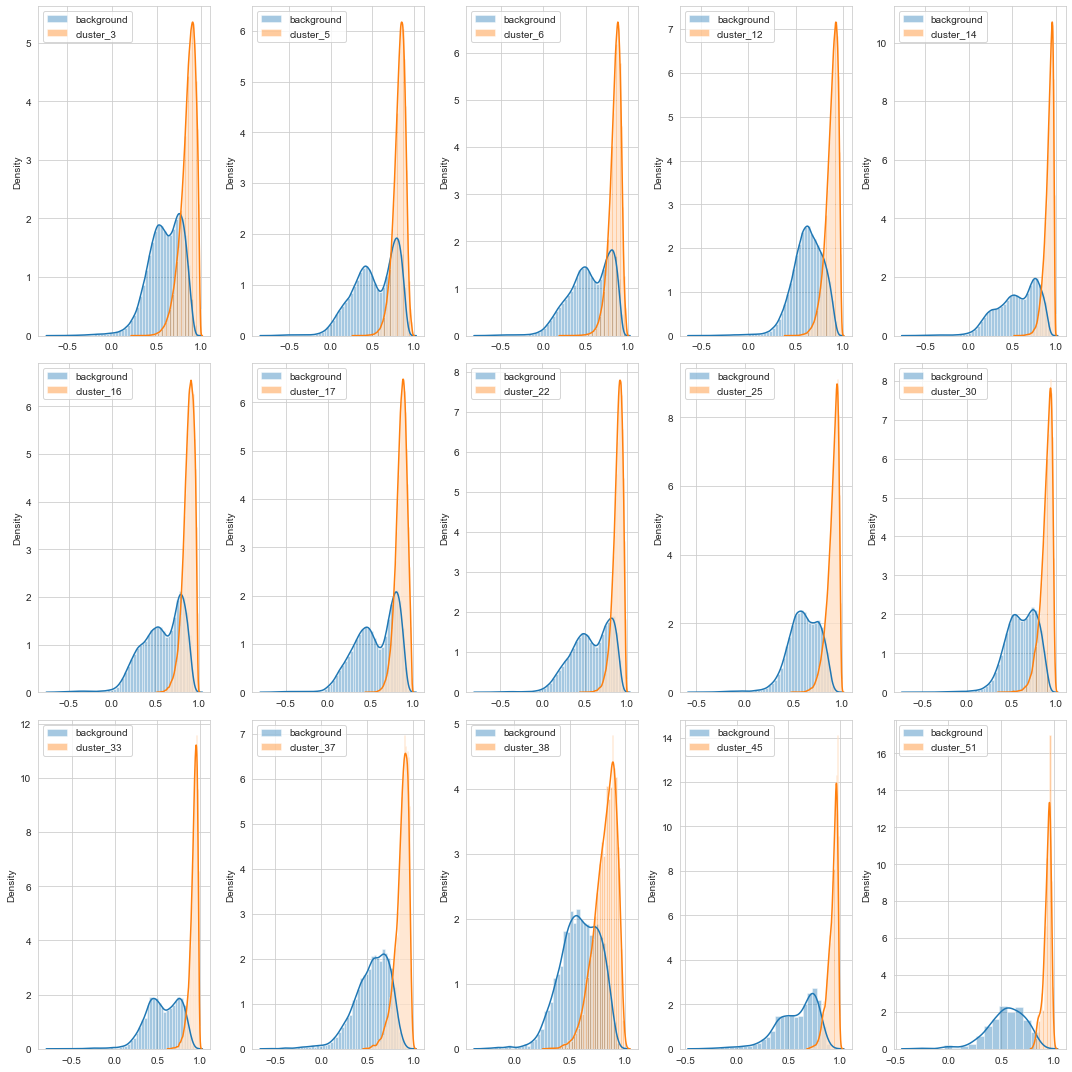

In [109]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_cols*3))
axes = axes.reshape(-1)


for i, cluster in enumerate(tqdm(react_leiden)):
    mask_cluster = (data_cd8te.obs['leiden_moe_cd8te'] == cluster).values
    corr_cluster = rs_squared[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    background = np.random.choice(background, size=corr_cluster.shape[0], replace=False)
    sb.distplot(background, label='background', ax=axes[i])
    sb.distplot(corr_cluster, label=f'cluster_{cluster}', ax=axes[i])
    axes[i].legend()
        
fig.tight_layout()
plt.show()

In [110]:
p_values = {}
for cluster in react_leiden:
    mask_cluster = (latent_moe_cd8ef.obs['leiden'] == cluster).values
    corr_cluster = rs_squared[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    p = scipy.stats.ttest_ind(a=corr_cluster, b=background, equal_var=False, alternative='greater')
    p_values[cluster] = p
p_values

{'3': Ttest_indResult(statistic=2055.970631088027, pvalue=0.0),
 '5': Ttest_indResult(statistic=2411.3302608696663, pvalue=0.0),
 '6': Ttest_indResult(statistic=2407.5350907241623, pvalue=0.0),
 '12': Ttest_indResult(statistic=1803.435145203301, pvalue=0.0),
 '14': Ttest_indResult(statistic=2452.2426384620853, pvalue=0.0),
 '16': Ttest_indResult(statistic=1373.6895398590761, pvalue=0.0),
 '17': Ttest_indResult(statistic=1339.7363937983914, pvalue=0.0),
 '22': Ttest_indResult(statistic=1425.0748382870834, pvalue=0.0),
 '25': Ttest_indResult(statistic=1045.5680392144266, pvalue=0.0),
 '30': Ttest_indResult(statistic=551.7107413679751, pvalue=0.0),
 '33': Ttest_indResult(statistic=740.6016319799613, pvalue=0.0),
 '37': Ttest_indResult(statistic=318.4518552915995, pvalue=0.0),
 '38': Ttest_indResult(statistic=162.07481613614533, pvalue=0.0),
 '45': Ttest_indResult(statistic=264.18937518285014, pvalue=0.0),
 '51': Ttest_indResult(statistic=149.87675190570937, pvalue=0.0)}

In [111]:
clusters = []
t_stats = []
p_vals = []

for c, summary in p_values.items():
    clusters.append(c)
    t_stats.append(summary[0])
    p_vals.append(summary[1])

df_s2_tcrdist = pd.DataFrame(data={'clusters': clusters, 't-statistic': t_stats, 'p-value': p_vals})
with pd.ExcelWriter('../results/supplement/s2_statistics_sars_cov_clusters.xlsx', mode='a') as writer:  
    df_s2_tcrdist.to_excel(writer, sheet_name='GEX_similarity')
df_s2_tcrdist

,clusters,t-statistic,p-value
0,3,2055.970631,0.0
1,5,2411.330261,0.0
2,6,2407.535091,0.0
3,12,1803.435145,0.0
4,14,2452.242638,0.0
5,16,1373.689540,0.0
6,17,1339.736394,0.0
7,22,1425.074838,0.0
8,25,1045.568039,0.0
9,30,551.710741,0.0
